In [1]:
import pandas as pd
import numpy as np

In [2]:
from gprofiler import GProfiler
gp = GProfiler(return_dataframe=True)

# IO

In [3]:
from PineBioML.preprocessing import IO

The data is from  [LinkedOmicsKB](https://kb.linkedomics.org/).

In [4]:
# Path
input_folder = "./input/"
output_folder = "./output/"
export_title = "StrategyII CCRCC "

In [5]:
# Read data
Normal = IO.read_file(input_folder+ "CCRCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Normal.txt").set_index("idx").T
Tumour = IO.read_file(input_folder+ "CCRCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.txt").set_index("idx").T

# Preprocessing

In [6]:
# Merge the dataframes
x = pd.concat([Normal, Tumour], axis = 0).reset_index(drop = True)
y = pd.Series(np.concatenate([np.zeros_like(Normal.index), np.ones_like(Tumour.index)], axis = 0)) == 1

In [7]:
x.head(5)

idx,ENSG00000000003.15,ENSG00000000419.12,ENSG00000000457.14,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,ENSG00000001461.17,ENSG00000001497.16,...,ENSG00000168701.19,ENSG00000181631.7,ENSG00000185046.18,ENSG00000187626.9,ENSG00000197580.13,ENSG00000205060.11,ENSG00000211645.2,ENSG00000218336.9,ENSG00000230667.5,ENSG00000243232.6
0,23.910682,25.408087,20.530891,18.652968,27.897499,25.799120,25.559402,18.816175,NaN,23.234695,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23.465741,25.284497,20.781890,19.239574,27.379201,25.720201,25.609840,19.186315,NaN,23.153964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23.688758,24.950765,20.792161,19.915342,28.317880,25.268082,25.164925,20.709017,NaN,23.627795,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23.753836,25.238511,20.878394,19.312896,28.491202,25.647752,25.857748,19.940423,NaN,23.216209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23.545379,25.241886,20.826577,NaN,28.192978,26.344376,25.673238,19.899800,20.191294,23.256864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Convert ENSEMBL ID to gene symbol by gprofiler
x.columns = [col.split(".")[0] for col in x.columns]
gene_name = gp.convert(query=x.columns.to_list())["name"]

# For those who can't find a gene symbol, they will remain in ENSEMBL ID
matched = gene_name == "None"
x.columns = x.columns.where(matched, gene_name)

# The result
x.head(5)

,TSPAN6,DPM1,SCYL3,FGR,CFH,FUCA2,GCLC,NFYA,NIPAL3,LAS1L,...,TMEM208,P2RY13,ANKS1B,ZKSCAN4,BCO2,SLC35B4,IGLV1-50,TENM3,SETSIP,PCDHAC2
0,23.910682,25.408087,20.530891,18.652968,27.897499,25.799120,25.559402,18.816175,NaN,23.234695,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23.465741,25.284497,20.781890,19.239574,27.379201,25.720201,25.609840,19.186315,NaN,23.153964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23.688758,24.950765,20.792161,19.915342,28.317880,25.268082,25.164925,20.709017,NaN,23.627795,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23.753836,25.238511,20.878394,19.312896,28.491202,25.647752,25.857748,19.940423,NaN,23.216209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23.545379,25.241886,20.826577,NaN,28.192978,26.344376,25.673238,19.899800,20.191294,23.256864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
### Revert to Original scale
x = np.power(2, x)

In [10]:
# Impute 0
from PineBioML.preprocessing import impute


# The imputer will drop the features with missing value more than 50%.
# Remaining will be filled by 0.
simple = impute.simple_imputer(threshold = 0.5, strategy = "constant")
original_x, y = simple.fit_transform(x, y)

x = x.T
x = (x - x.mean()) / x.std()
x = x.T

simple = impute.simple_imputer(threshold = 0.5, strategy = "constant")
x, y = simple.fit_transform(x, y)


# retsult
x.head(5)

,TSPAN6,DPM1,SCYL3,FGR,CFH,FUCA2,GCLC,NFYA,LAS1L,ENPP4,...,IGHV1-69D,PAGR1,IGHV3-64D,IGHV5-10-1,IQCJ-SCHIP1,SCO2,MIURF,ENSG00000285723,ASDURF,DERPC
0,-0.279362,-0.007706,-0.414037,-0.424456,1.933774,0.123254,0.038810,-0.423990,-0.335098,-0.246269,...,-0.424409,0.000000,-0.321311,-0.304823,-0.423619,0.030465,-0.400230,-0.356396,-0.413177,-0.352781
1,-0.317653,-0.030465,-0.413585,-0.425196,1.280711,0.110846,0.070923,-0.425416,-0.339734,-0.237496,...,-0.424392,0.000000,-0.333239,-0.343967,-0.426172,0.002831,-0.400748,-0.343978,-0.416616,-0.348453
2,-0.291242,-0.067870,-0.429536,-0.439306,3.502091,0.026381,-0.006560,-0.430738,-0.297852,-0.262184,...,-0.438361,0.000000,-0.184626,-0.396809,-0.443709,-0.140794,-0.421267,-0.388834,-0.432545,-0.339986
3,-0.285824,-0.052441,-0.397903,-0.409611,3.045696,0.066665,0.142227,-0.406356,-0.326192,-0.193533,...,-0.406896,0.000000,-0.263291,-0.219027,-0.411155,0.003490,-0.385817,-0.335798,-0.403595,-0.332487
4,-0.284637,-0.042263,-0.376356,0.000000,2.317916,0.359873,0.079893,-0.384143,-0.304239,-0.239031,...,0.000000,-0.382055,-0.182175,-0.104312,-0.386007,0.097613,-0.356201,-0.299557,-0.381152,-0.318474


In [11]:
original_x.head(5)

,TSPAN6,DPM1,SCYL3,FGR,CFH,FUCA2,GCLC,NFYA,LAS1L,ENPP4,...,IGHV1-69D,PAGR1,IGHV3-64D,IGHV5-10-1,IQCJ-SCHIP1,SCO2,MIURF,ENSG00000285723,ASDURF,DERPC
0,1.577003e+07,4.452421e+07,1.515005e+06,412195.029998,2.500253e+08,5.838602e+07,4.944778e+07,4.615653e+05,9.870520e+06,1.927286e+07,...,4.171632e+05,0.000000e+00,1.132988e+07,1.307512e+07,500761.839790,4.856449e+07,2.976494e+06,7.616187e+06,1.606048e+06,7.998814e+06
1,1.158489e+07,4.086881e+07,1.802902e+06,618997.312051,1.745664e+08,5.527797e+07,5.120709e+07,5.965628e+05,9.333354e+06,1.975832e+07,...,7.009272e+05,0.000000e+00,9.995554e+06,8.901724e+06,519397.129831,4.426385e+07,3.111857e+06,8.900577e+06,1.493852e+06,8.444307e+06
2,1.352156e+07,3.242864e+07,1.815784e+06,988815.550948,3.346041e+08,4.040644e+07,3.761815e+07,1.714096e+06,1.296209e+07,1.598119e+07,...,1.068798e+06,0.000000e+00,2.254598e+07,4.585925e+06,616126.588622,2.625604e+07,2.515705e+06,5.260971e+06,1.561090e+06,9.395700e+06
3,1.414546e+07,3.958667e+07,1.927626e+06,651269.819153,3.773170e+08,5.257057e+07,6.080757e+07,1.006156e+06,9.744856e+06,2.420615e+07,...,9.472778e+05,0.000000e+00,1.660177e+07,2.142705e+07,482998.878520,4.568375e+07,3.245089e+06,8.697766e+06,1.307165e+06,9.058640e+06
4,1.224236e+07,3.967937e+07,1.859621e+06,0.000000,3.068542e+08,8.520154e+07,5.350751e+07,9.782205e+05,1.002337e+07,1.740495e+07,...,0.000000e+00,1.214560e+06,2.384113e+07,3.265534e+07,767109.170522,5.551350e+07,4.141263e+06,1.055341e+07,1.316724e+06,8.411947e+06


# Feature selection

In [12]:
from PineBioML.selection.ensemble import selector
from PineBioML.selection.Volcano import Volcano_selection

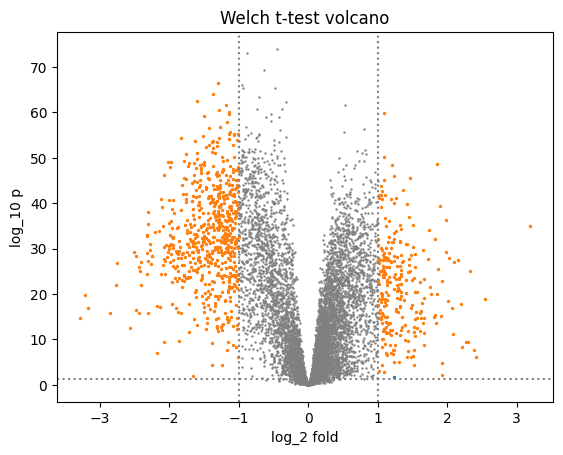

In [13]:
# Using volcano plot to select feature.
vol = Volcano_selection(strategy = "p", log_domain=False, absolute= False)
vol_importance = vol.Select(
    original_x, y, -1)  # The number of features to select, and -1 means choose all.

# Plot the vlcano plot.
vol.plotting()

In [14]:
# Use several way to select features, which includes decision tree, random forest, lasso, multi lasso, svm, adaboost, xgboost
ensemble_selector = selector(center=True, scale=True)
important_feature, importance = ensemble_selector.Select(x, y, 100)

Using  c45  to select.


100%|██████████| 9028/9028 [00:29<00:00, 306.48it/s]


c45  is done.

Using  RF_gini  to select.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

RF_gini  is done.

Using  AdaBoost  to select.
I don't have a progress bar but I am running
AdaBoost  is done.

Using  Lasso_Bisection  to select.


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.534e-01, tolerance: 4.575e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.275e-02, tolerance: 4.575e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pac

Lasso_Bisection  is done.

Using  multi_Lasso  to select.


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.534e-01, tolerance: 4.575e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.680e-01, tolerance: 4.575e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pac

multi_Lasso  is done.

Using  SVM  to select.
SVM  is done.

Using  XGboost  to select.


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(

XGboost  is done.



In [15]:
# The features that was selected by ML algoritms.
important_feature

,DT_score_c45,RandomForest_gini,AdaBoost128,LassoLinear,multi_Lasso,SVM,XGboost
0,TRADD,SUOX,DOCK4,COL18A1,ADH1C,UMOD,PFDN4
1,DOCK4,TRADD,NaN,FBLN5,COX6B1,HBD,WWC3
2,IPO9,PDK1,NaN,HADH,HADH,PGK1,MYO9B
3,PFKP,IPO9,NaN,COL14A1,ADH1B,FN1,TRADD
4,EGFR,DPP9,NaN,FHL2,NDUFA4,BGN,ITGAL
...,...,...,...,...,...,...,...
95,SPATA18,PALD1,NaN,AHNAK,GM2A,IGHG3,NaN
96,SVBP,CASP8,NaN,IGHA1,ALDH1A1,ADIRF,NaN
97,NDUFS1,NDUFS2,NaN,GRAMD1A,APOA1,ALDH6A1,NaN
98,LTC4S,PSMD10,NaN,TYMP,TNC,IDH2,NaN


In [16]:
# The feature importance given by diffirent methods.
# Please Notice that the score between diffirent methods is not comparable.
importance

,DT_score_c45,RandomForest_gini,AdaBoost128,LassoLinear,multi_Lasso,SVM,XGboost
TRADD,0.681052,0.008976,NaN,NaN,NaN,NaN,0.081246
DOCK4,0.681052,0.008236,1.0,NaN,NaN,NaN,NaN
IPO9,0.681052,0.008645,NaN,NaN,NaN,NaN,NaN
PFKP,0.680516,0.005876,NaN,NaN,0.019123,0.002427,NaN
EGFR,0.680036,0.004641,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
OGN,NaN,NaN,NaN,NaN,NaN,0.001157,NaN
ADIRF,NaN,NaN,NaN,NaN,NaN,0.001157,NaN
NID1,NaN,NaN,NaN,NaN,NaN,0.001145,NaN
ITGAL,NaN,NaN,NaN,NaN,NaN,NaN,0.022916


# Analysis utils

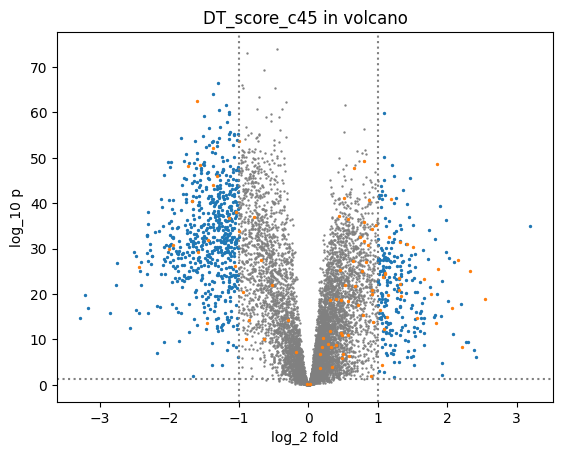

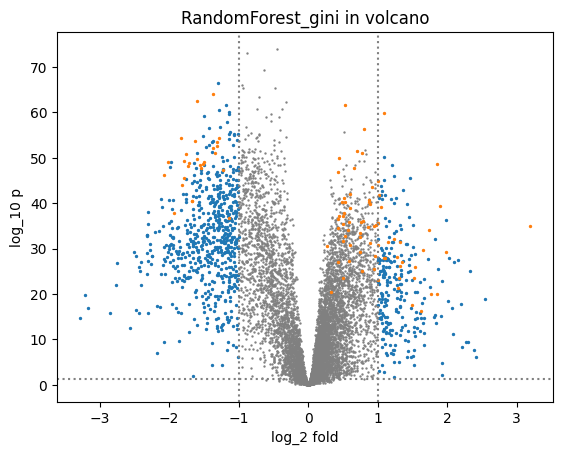

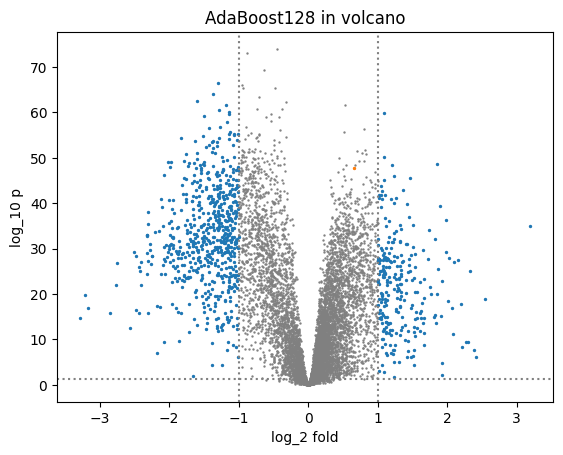

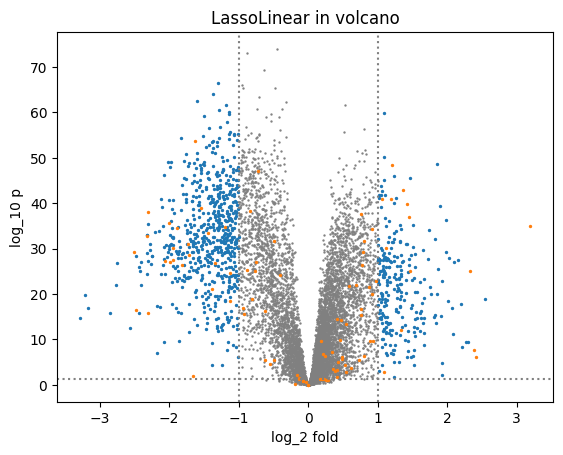

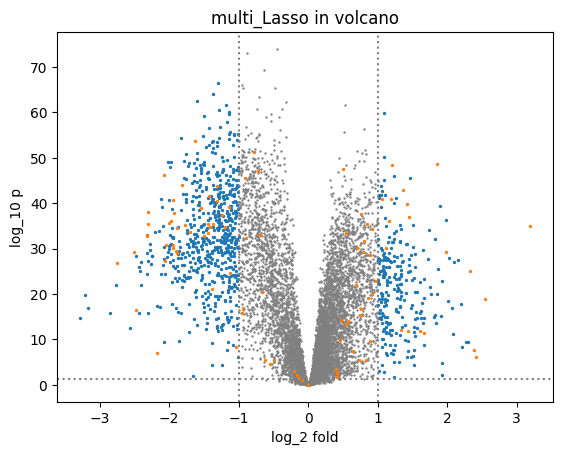

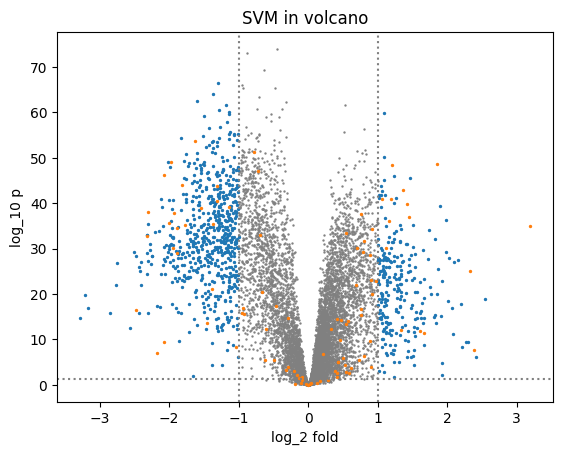

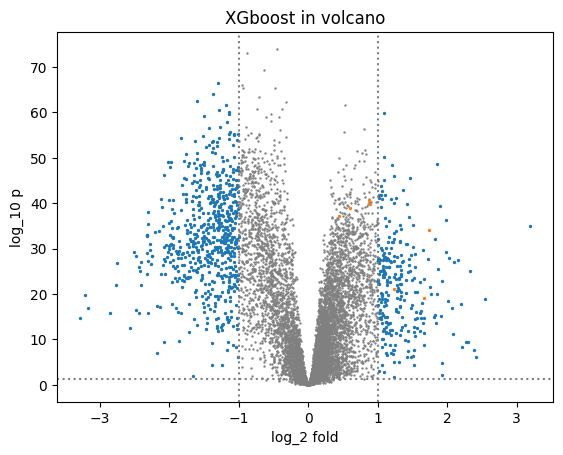

In [17]:
### Plot important features from diffirent methods on volcano plot.
for method in importance:
    vol.plotting(external=True,
                 external_score=importance[method].dropna(),
                 title=method + " in volcano",
                 show=False,
                 saving=True,
                 save_path="./output/images/" + export_title)

In [18]:
# Using g:profiler to do gene enrichment.
gp_enrichment_result = []
for method in important_feature.columns:
    gp_result = gp.profile(query = important_feature[method].dropna().to_list()).sort_values("p_value")
    gp_result["method"] = method
    gp_enrichment_result.append(gp_result[["method", "source", "native", "parents", "p_value", "description", "intersection_size"]])
gp_enrichment_result = pd.concat(gp_enrichment_result,
                                 axis=0).reset_index(drop=True)
# The result
gp_enrichment_result

C:\Users\aimhi\AppData\Local\Temp\ipykernel_2092\189993588.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gp_enrichment_result = pd.concat(gp_enrichment_result,


,method,source,native,parents,p_value,description,intersection_size
0,DT_score_c45,GO:CC,GO:0005737,"[GO:0005622, GO:0110165]",4.535383e-08,"""The contents of a cell excluding the plasma m...",85
1,DT_score_c45,GO:BP,GO:0044281,[GO:0008152],3.156837e-07,"""The chemical reactions and pathways involving...",30
2,DT_score_c45,GO:BP,GO:0055086,"[GO:0006139, GO:0044281]",1.831683e-05,"""The cellular chemical reactions and pathways ...",17
3,DT_score_c45,GO:BP,GO:0009117,[GO:0006753],1.681740e-04,"""The chemical reactions and pathways involving...",15
4,DT_score_c45,GO:BP,GO:0006091,[GO:0044237],1.695102e-04,"""The chemical reactions and pathways resulting...",14
...,...,...,...,...,...,...,...
1296,SVM,GO:BP,GO:0019682,"[GO:0006081, GO:0006796, GO:0019637, GO:1901135]",4.614261e-02,"""The chemical reactions and pathways involving...",3
1297,SVM,HPA,HPA:0480893,[HPA:0480892],4.735423e-02,small intestine; goblet cells[High],8
1298,SVM,HPA,HPA:0150893,[HPA:0150892],4.735423e-02,duodenum; goblet cells[High],8
1299,SVM,GO:MF,GO:0070052,[GO:0005518],4.970687e-02,"""Binding to a type V collagen trimer."" [GOC:BH...",2


In [19]:
# Showing the top 10 significant result
gp_enrichment_result.sort_values("p_value").head(20)

,method,source,native,parents,p_value,description,intersection_size
949,SVM,GO:CC,GO:0070062,"[GO:0005615, GO:1903561]",4.659478e-58,"""A vesicle that is released into the extracell...",78
950,SVM,GO:CC,GO:1903561,"[GO:0031982, GO:0065010]",1.116804e-57,"""Any vesicle that is part of the extracellular...",78
951,SVM,GO:CC,GO:0065010,"[GO:0043227, GO:0043230]",1.157971e-57,"""Organized structure of distinctive morphology...",78
952,SVM,GO:CC,GO:0043230,"[GO:0005576, GO:0043226]",1.157971e-57,"""Organized structure of distinctive morphology...",78
953,SVM,GO:CC,GO:0005615,"[GO:0005576, GO:0110165]",1.163288e-51,"""That part of a multicellular organism outside...",84
574,multi_Lasso,GO:CC,GO:0070062,"[GO:0005615, GO:1903561]",2.818549e-47,"""A vesicle that is released into the extracell...",71
575,multi_Lasso,GO:CC,GO:1903561,"[GO:0031982, GO:0065010]",6.164908e-47,"""Any vesicle that is part of the extracellular...",71
576,multi_Lasso,GO:CC,GO:0065010,"[GO:0043227, GO:0043230]",6.367963e-47,"""Organized structure of distinctive morphology...",71
577,multi_Lasso,GO:CC,GO:0043230,"[GO:0005576, GO:0043226]",6.367963e-47,"""Organized structure of distinctive morphology...",71
954,SVM,GO:CC,GO:0005576,[GO:0110165],2.156768e-44,"""The space external to the outermost structure...",85


# Modeling

In [20]:
from sklearn.svm import SVC
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [21]:
# create an optuna tuner for support vector classifier
class SVC_tuner():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __call__(self, trial):
        svc_c = trial.suggest_float("svc_c", 1e-5, 1e3, log=True)
        classifier_obj = SVC(C = svc_c, cache_size = 1e+3, class_weight = "balanced", gamma="auto", probability=True)
        
        score = cross_val_score(classifier_obj, self.x, self.y, n_jobs=-1, cv=5, scoring = "neg_log_loss")#
        accuracy = score.mean()
        return accuracy

In [22]:


svm_performance = []
for k in [5, 10, 20]:
    performance = {}
    for method in important_feature.columns:
        top_k = important_feature.head(k)[method].dropna()
        task = SVC_tuner(x[top_k], y)
        study = optuna.create_study(direction="maximize")
        study.optimize(task, n_trials=100)

        best_svc_c = study.best_trial.params["svc_c"]

        best_svc = SVC(C=best_svc_c,
                       probability=True,
                       cache_size=1e+3,
                       class_weight="balanced",
                       gamma="auto").fit(x[top_k], y)
        prob = best_svc.predict_proba(x[top_k])

        performance[method] = roc_auc_score(y, (prob[:, 1] +
                                                (1 - prob[:, 0])) / 2)
    svm_performance.append(pd.Series(performance, name="top" + str(k)))

#The result
svm_performance = pd.concat(svm_performance, axis=1)
svm_performance

[I 2024-06-21 03:10:03,989] A new study created in memory with name: no-name-add7cea8-0b49-4824-a464-4ca4e0ddf096
[I 2024-06-21 03:10:06,722] Trial 0 finished with value: -0.7101457614295864 and parameters: {'svc_c': 0.0014754203535687462}. Best is trial 0 with value: -0.7101457614295864.
[I 2024-06-21 03:10:08,232] Trial 1 finished with value: -0.7036726212474701 and parameters: {'svc_c': 0.00014785425044900593}. Best is trial 1 with value: -0.7036726212474701.
[I 2024-06-21 03:10:08,284] Trial 2 finished with value: -0.7057294889856224 and parameters: {'svc_c': 3.128692567508266e-05}. Best is trial 1 with value: -0.7036726212474701.
[I 2024-06-21 03:10:08,319] Trial 3 finished with value: -0.05037193219811524 and parameters: {'svc_c': 918.0039356854866}. Best is trial 3 with value: -0.05037193219811524.
[I 2024-06-21 03:10:08,365] Trial 4 finished with value: -0.6540522031218503 and parameters: {'svc_c': 0.005414586470416747}. Best is trial 3 with value: -0.05037193219811524.
[I 2024

,top5,top10,top20
DT_score_c45,0.995874,1.0,1.0
RandomForest_gini,1.000000,1.0,1.0
AdaBoost128,1.000000,1.0,1.0
LassoLinear,1.000000,1.0,1.0
multi_Lasso,1.000000,1.0,1.0
SVM,1.000000,1.0,1.0
XGboost,1.000000,1.0,1.0


# Output

In [23]:
# Save the result ro output_path
important_feature.to_csv(output_folder + export_title + " important feature.csv")
importance.to_csv(output_folder+export_title+ " importance.csv")
gp_enrichment_result.to_csv(output_folder+export_title+ " g_prophiler.csv")
svm_performance.to_csv(output_folder+export_title+ " rbfSVM_performance.csv")
vol_importance.to_csv(output_folder + export_title + " volcano_foldchange.csv")